<a href="https://colab.research.google.com/github/darthgera123/Diffusion-Relighting/blob/main/Inference_ControlNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ControlNet Experiments
In this notebook we experiment with different settings of control net to see how network conditioned on different quantities reflect the output. We see the effect of depth, normal and pose.

## How does it work
Control Net creates a copy of the main network. Then it freezes the original network and adds the output of each layer of copied network to the main network. The highway connections are passed through a zero convolution block to protect it against abrupt gradient changes. Thus we dont overfit the capabilities of original network while also add the learnt features of the new conditioning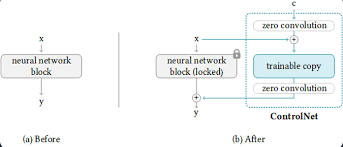

## Install Libraries

In [1]:
!pip install -q diffusers transformers accelerate
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 4.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openxlab 0.1.1 requires requests~=2.28.2, but you have requests 2.32.3 which is incompatible.


In [2]:
!pip install -U controlnet-aux

In [ ]:
!pip install -U openmim
!mim install mmengine
!mim install "mmcv>=2.0.1"
!mim install "mmdet>=3.1.0"
!mim install "mmpose>=1.1.0"

## Depth conditioning

In [100]:
import torch
import numpy as np
from transformers import pipeline
from diffusers.utils import load_image, make_image_grid

# image = load_image(
#     "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/controlnet-img2img.jpg"
# )


def get_depth_map(image,depth_estimator):
    depth = depth_estimator(image)['depth']
    image = np.array(depth)
    image = image[:,:,None]
    image = np.concatenate([image,image,image],axis=2)
    detected_map = torch.from_numpy(image).float()/ 255.0
    depth_map = detected_map.permute(2,0,1)
    return depth_map
depth_estimator = pipeline("depth-estimation")


No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [101]:
image = load_image(
    "/content/drive/MyDrive/3dgs/Cam_05.png"
)
depth_map = depth_estimator(image)['depth']
depth_map_cuda = get_depth_map(image,depth_estimator).unsqueeze(0).half().to("cuda")

In [102]:
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [103]:
# prompt: widget to take a prompt that can passed later as a variable

prompt = "Anime girl in a cyberpunk world, Arcane style with detailed, realistic shoes, a non-NSFW high-tech outfit, glowing neon accents, and a vibrant Cute anime girl in a non-NSFW winter outfit, posing for cameras, with a focus on her detailed face, expressive eyes, and a warm smile, while wearing a cozy coat, scarf, and mittens. of towering skyscrapers and holographic ads." #@param {type:"string"}


Token indices sequence length is longer than the specified maximum sequence length for this model (87 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['of towering skyscrapers and holographic ads.']


  0%|          | 0/40 [00:00<?, ?it/s]

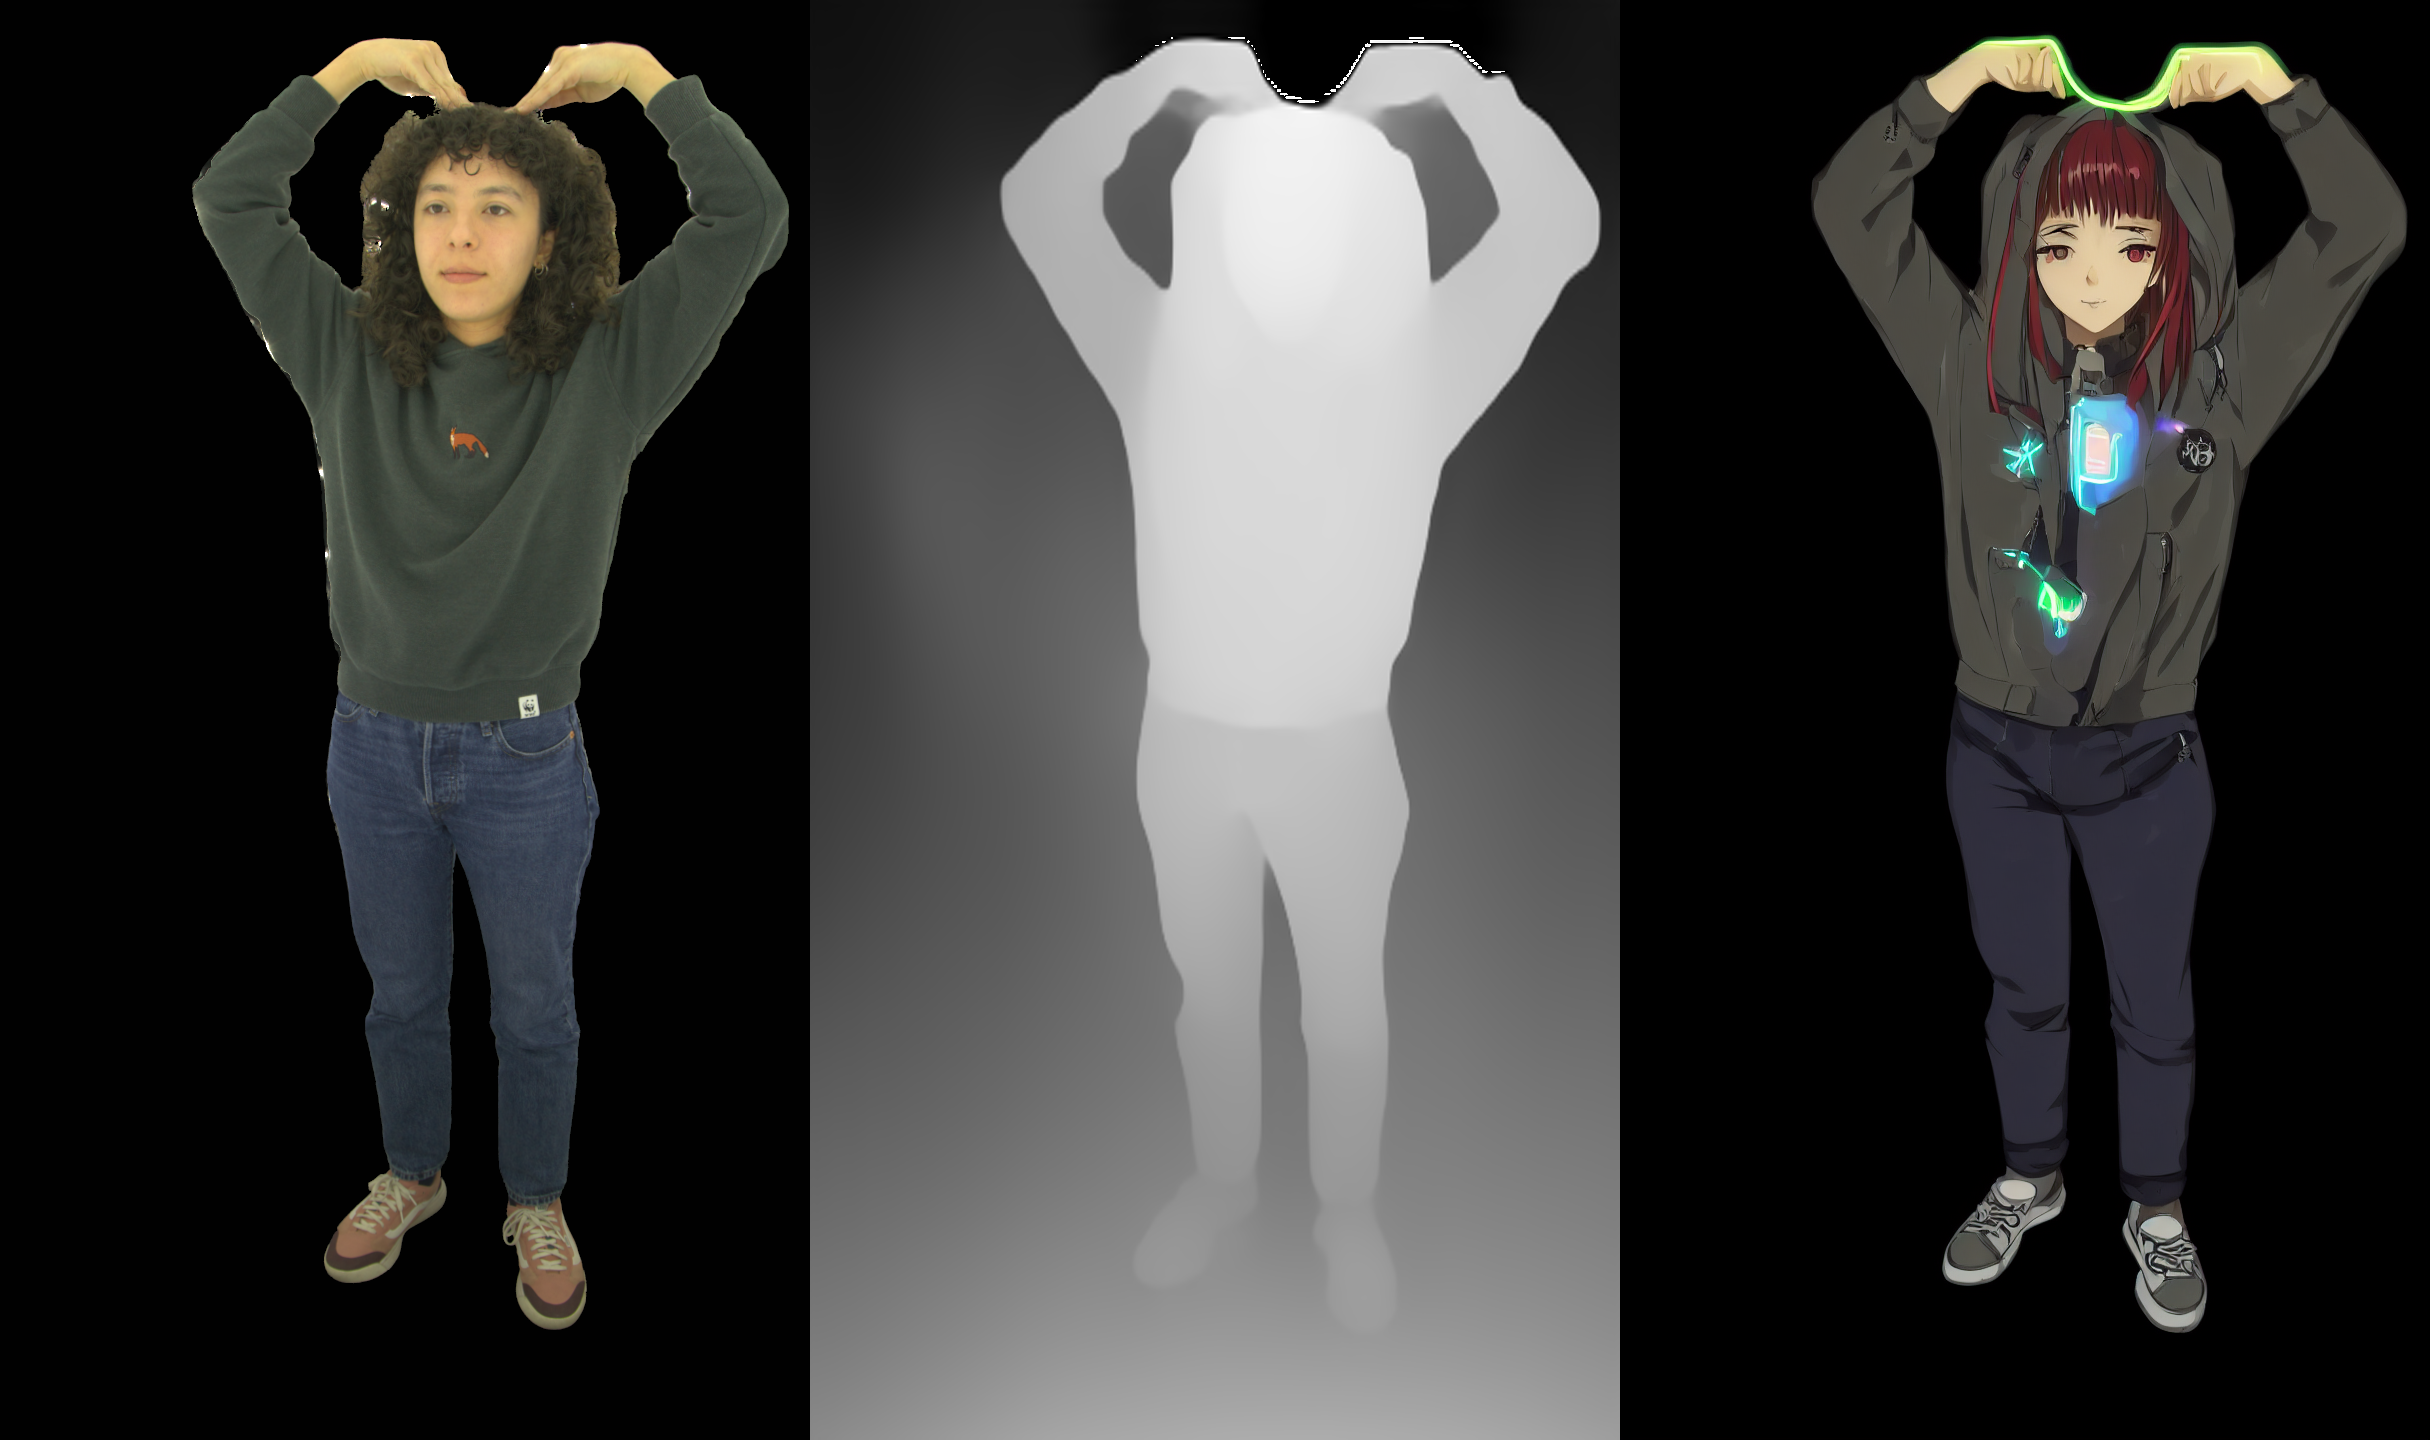

In [104]:
output = pipe(
    prompt,
    image=image,
    control_image=depth_map
).images[0]
make_image_grid([image,depth_map, output], 1, 3)

## Normal Conditioning


In [105]:
# image2 = load_image(
#     "https://huggingface.co/lllyasviel/control_v11p_sd15_normalbae/resolve/main/images/input.png"
# )
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_normalbae", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [106]:
from controlnet_aux import NormalBaeDetector
from controlnet_aux.processor import Processor
normal_detector = NormalBaeDetector.from_pretrained("lllyasviel/Annotators")

Loading base model ()...Done.
Removing last two layers (global_pool & classifier).


In [107]:
image2 = load_image(
    "/content/drive/MyDrive/3dgs/Cam_05.png"
)
normal_image = normal_detector(image2)
normal_image_resized = normal_image.resize(image2.size)

In [108]:
# prompt: widget to take a prompt that can passed later as a variable

prompt = "Cute anime girl in a non-NSFW winter outfit, posing for cameras, with a focus on her detailed face, expressive eyes, and a warm smile, while wearing a cozy coat, scarf, and mittens." #@param {type:"string"}


  0%|          | 0/24 [00:00<?, ?it/s]

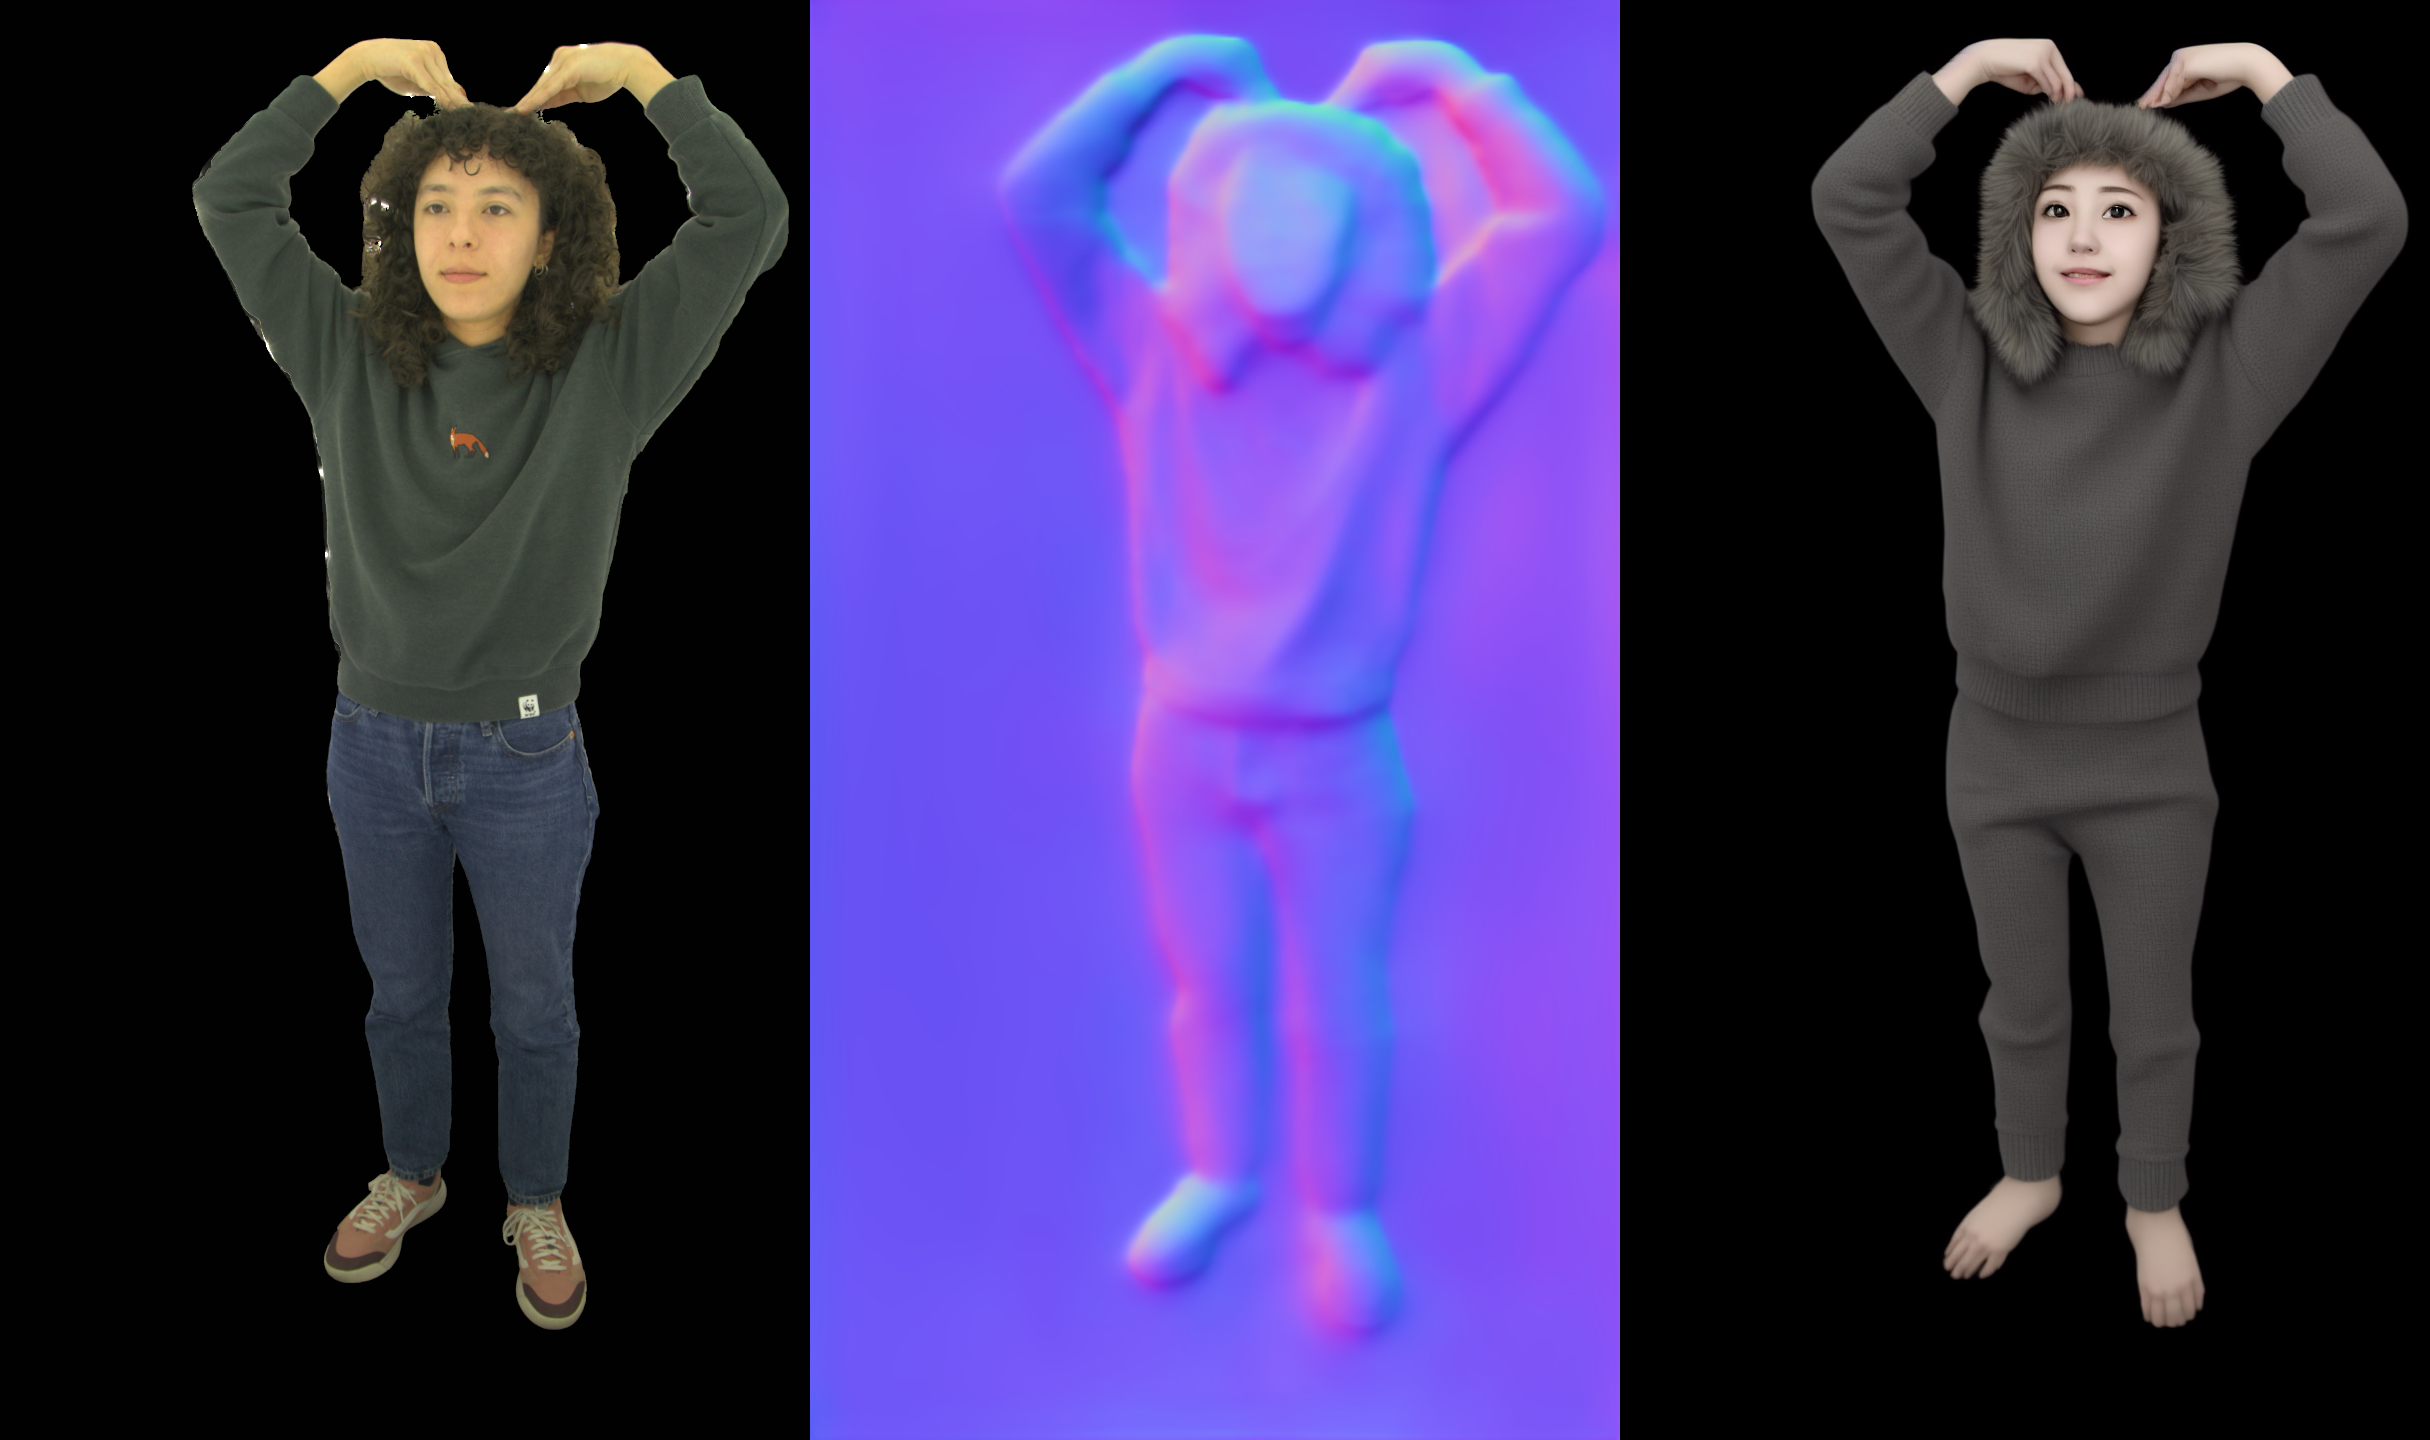

In [109]:
output = pipe(prompt, \
              num_inference_steps=30, \
              image=image2, \
              control_image=normal_image_resized
            ).images[0]

make_image_grid([image2,normal_image_resized, output], 1, 3)

## Pose Detector

In [111]:
from controlnet_aux import OpenposeDetector
open_pose = OpenposeDetector.from_pretrained("lllyasviel/Annotators")
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [112]:

# image3 = load_image(
#     "https://huggingface.co/lllyasviel/sd-controlnet-openpose/resolve/main/images/pose.png"
#     )
image3 = load_image(
    "/content/drive/MyDrive/3dgs/Cam_05.png"
    )
pose_image = open_pose(image3)
pose_image_resized = pose_image.resize(image3.size)

In [113]:
# prompt: widget to take a prompt that can passed later as a variable

prompt = "Cute anime girl in a non-NSFW winter outfit, posing for cameras, with a focus on her detailed face, expressive eyes, and a warm smile, while wearing a cozy coat, scarf, and mittens." #@param {type:"string"}


  0%|          | 0/24 [00:00<?, ?it/s]

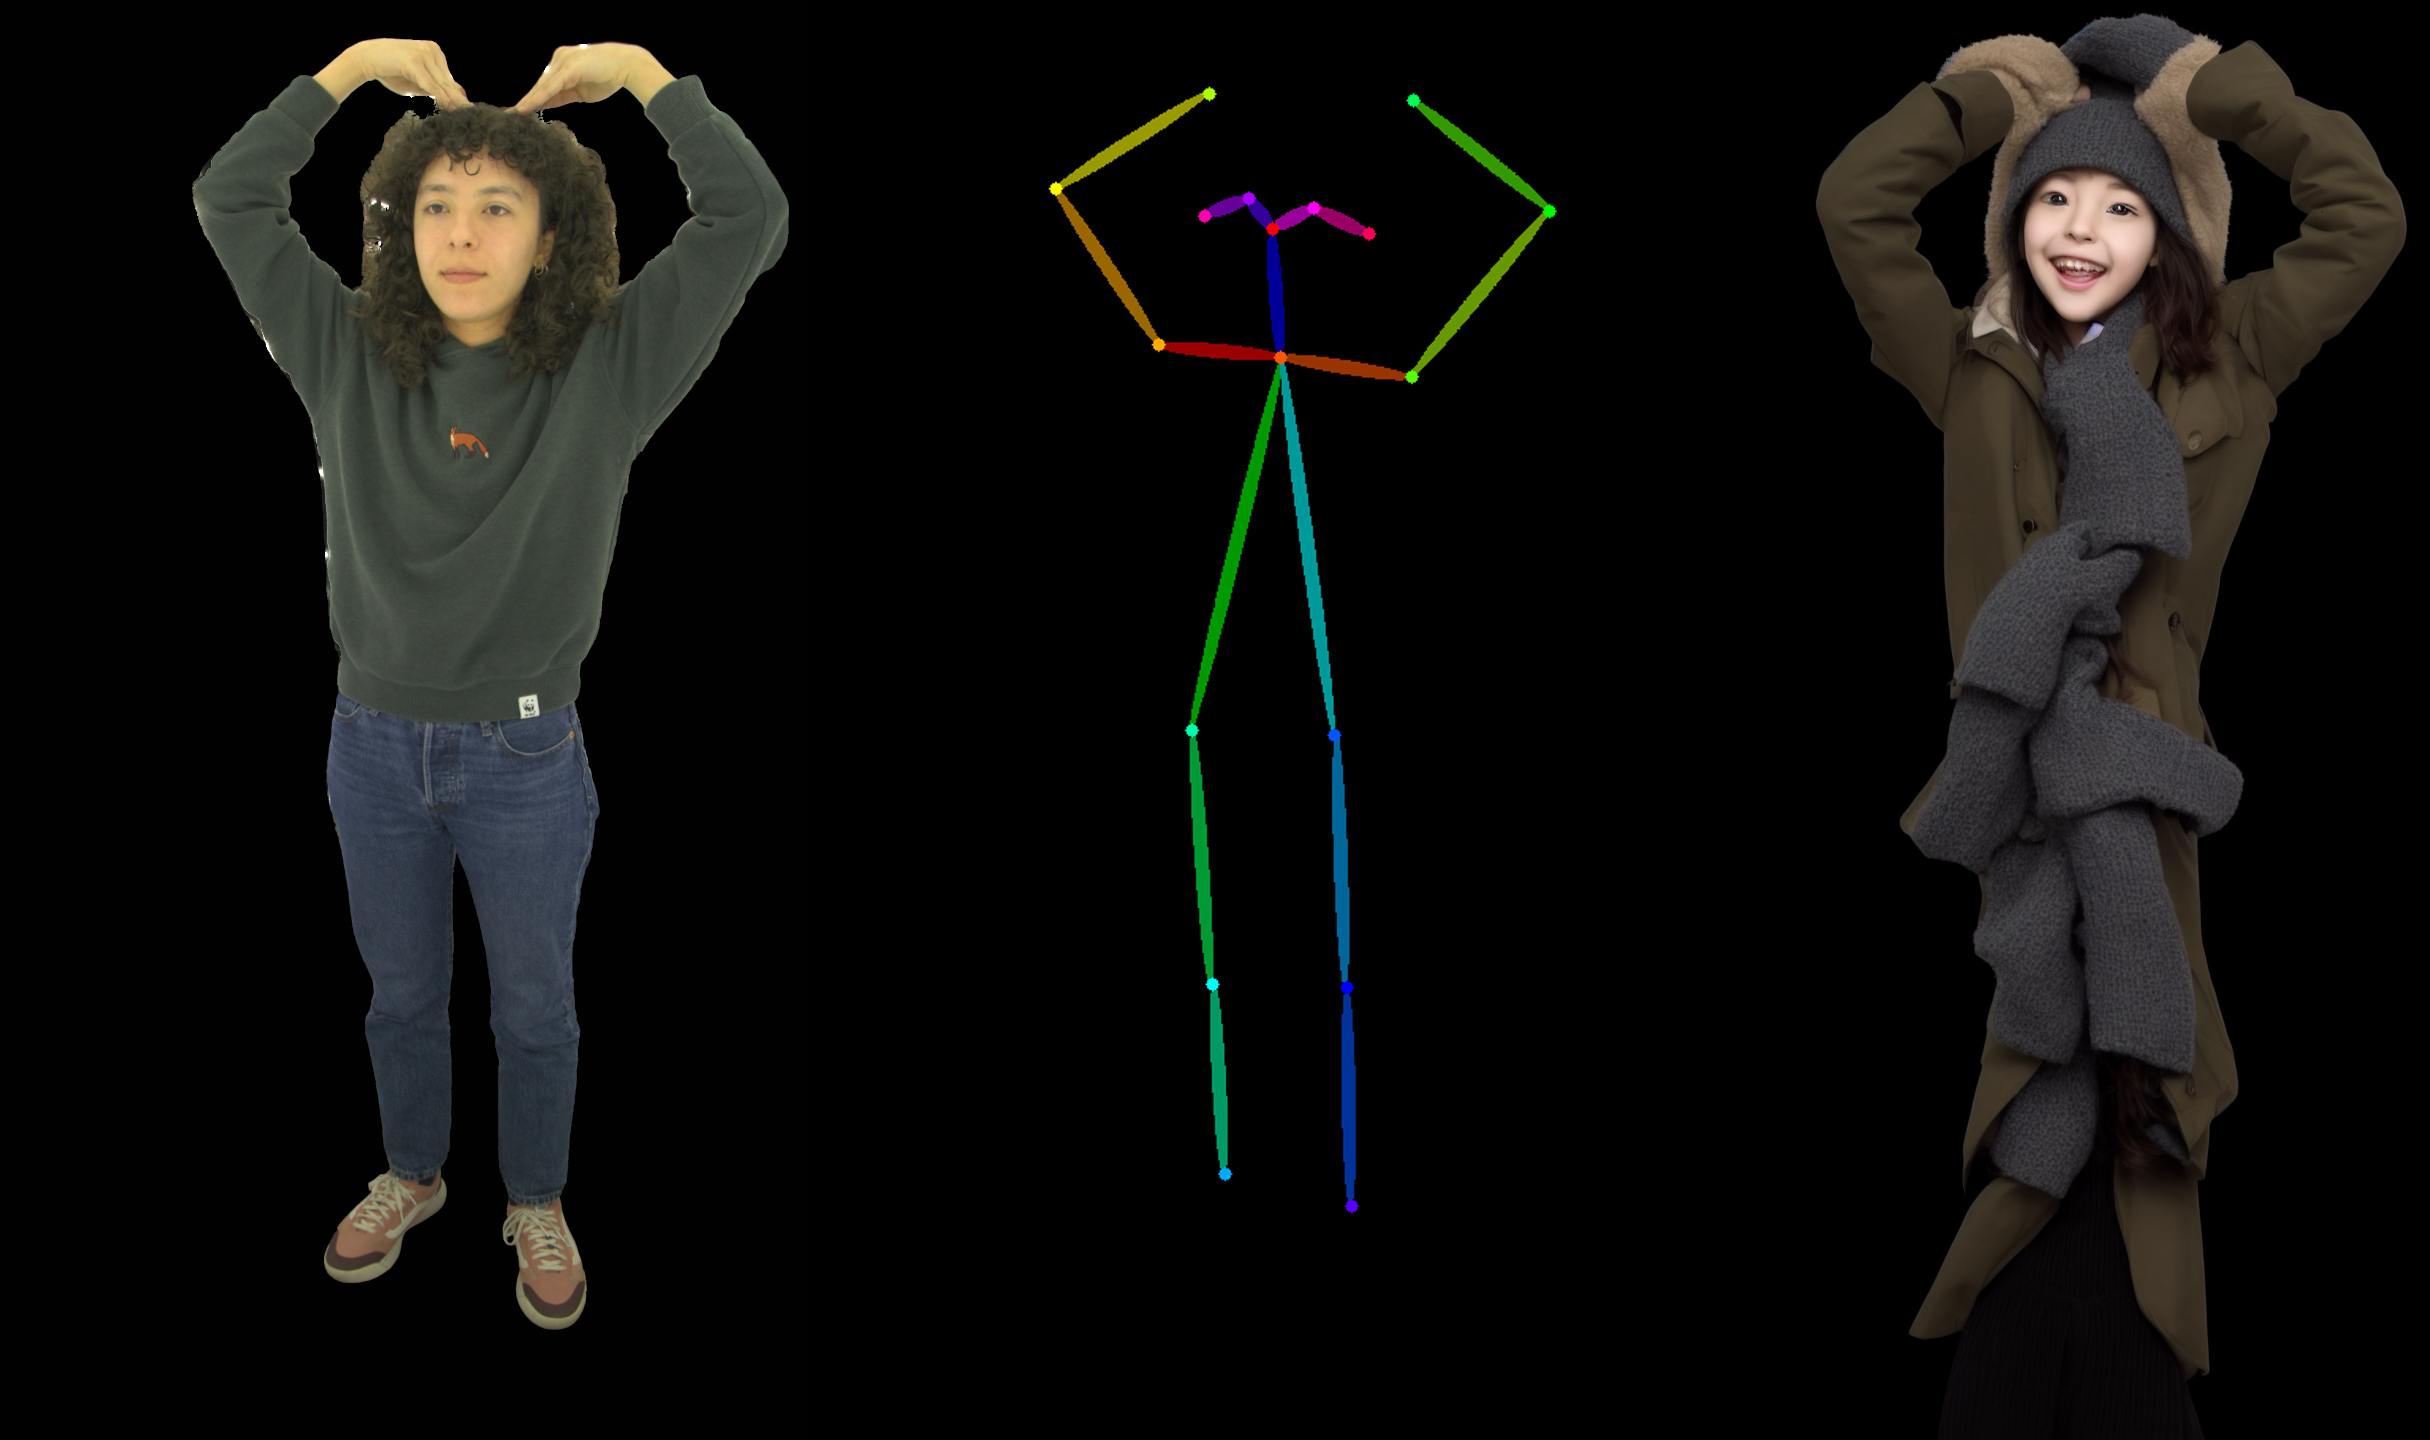

In [114]:
device='cuda'
# generator = torch.Generator(device=device).manual_seed(42)
output = pipe(prompt, \
              num_inference_steps=30, \
              image=image3, \
              control_image=pose_image_resized,
            ).images[0]
make_image_grid([image3, pose_image_resized,output], 1, 3)